# Google Notebook specific Stuff

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install pytorch-lightning==1.3.3
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
!pip install scGeneFit
!pip install scanpy
!pip install anndata
!pip install lassonet
# my version of smashpy that fixed imports, nothing else was changed
!pip install matplotlib>=3.3.2
!pip install shap>=0.37.0
!pip install xgboost>=1.3.3
!pip install imbalanced-learn>=0.7.0
!pip install numba>=0.51.2
!pip install harmonypy>=0.0.5
!git clone https://github.com/beelze-b/SmashFork.git
!git clone https://github.com/ahsv/RankCorr.git

     |████████████████████████████████| 806 kB 4.2 MB/s 
     |████████████████████████████████| 829 kB 38.8 MB/s 
     |████████████████████████████████| 282 kB 49.5 MB/s 
     |████████████████████████████████| 119 kB 64.9 MB/s 
     |████████████████████████████████| 636 kB 38.6 MB/s 
     |████████████████████████████████| 1.3 MB 34.1 MB/s 
     |████████████████████████████████| 142 kB 57.3 MB/s 
     |████████████████████████████████| 294 kB 57.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=2c12943d1461195199ce9e700eeb1c4d0bf07c937bbdae80b14f8d7a2be79f6a
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [3]:
# Check GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
import sys
import os
# to import utils
sys.path.append(os.path.abspath('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks'))

# All the Imports

In [5]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lassonet import LassoNetClassifier

from RankCorr.picturedRocks import Rocks
import SmashFork.smashpy as smashpy
import anndata


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part o

CPU times: user 21.6 s, sys: 1.06 s, total: 22.6 s
Wall time: 28.2 s


# These should be parameters later on 

In [6]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k = 50
num_times = 5

gpus = 1
tpu_cores = None

In [7]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [8]:
from os import path

In [9]:
dataset_dirs = ['/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/developmental_mouse/',
               '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/CITE-seq/',
               '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/synthetic/'
]


model_save_path = '{}/models/'
viz_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/embedding_map_aggregate.png'

# Dataset Specific Processing

### Developmental Mouse

In [10]:
deng = pd.read_csv(dataset_dirs[0] + 'deng_counts.txt', sep =' ')

deng_meta = pd.read_csv(dataset_dirs[0] + 'deng_metadata.txt', sep =' ')
#this is an early mouse data, so there are very few cells
deng_adata = sc.AnnData(deng.T)
deng_adata,deng_meta.shape
#deng_adata.X

# create a joint dictionary to compare time points
# based on work from here 10.1172/JCI41229
mouse_stage={}
# '16cell' '4cell' '8cell' 'early2cell' 'earlyblast' 'late2cell'
# 'lateblast' 'mid2cell' 'midblast' 'zy1' 'zy2' 'zy3' 'zy4']


mouse_stage['zy1'] = 'less4cell'
mouse_stage['zy2'] = 'less4cell'
mouse_stage['zy3'] = 'less4cell'
mouse_stage['zy4'] = 'less4cell'

mouse_stage['early2cell'] = 'less4cell'
mouse_stage['mid2cell'] = 'less4cell'
mouse_stage['late2cell'] = 'less4cell'
mouse_stage['4cell'] = 'less4cell'
mouse_stage['8cell'] = '8cell'
mouse_stage['16cell'] = '16cell'
mouse_stage['earlyblast'] = 'earlyblast'
mouse_stage['midblast'] = 'midblast'
mouse_stage['lateblast'] = 'lateblast'

new_annot = [mouse_stage[key]  for key in deng_meta['orig.ident'].values]
deng_adata.obs['annotation'] = new_annot
deng_adata.obs['annotation'] = deng_adata.obs['annotation'].astype('category')

sc.pp.filter_cells(deng_adata, min_genes=10)
sc.pp.filter_genes(deng_adata, min_cells=3)

deng_adata.var['mt'] = deng_adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(deng_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

p = 0.95
deng_adata = deng_adata[deng_adata.obs.n_genes_by_counts < p* max(deng_adata.obs.n_genes_by_counts),:]
deng_adata = deng_adata[deng_adata.obs.pct_counts_mt <0.8,:]

sc.pp.normalize_total(deng_adata, target_sum=1e4)
sc.pp.log1p(deng_adata)
sc.pp.scale(deng_adata)

X_dm = deng_adata.X.copy()
labels = deng_adata.obs['annotation'].values
encoder_dm = LabelEncoder()
encoder_dm.fit(labels)
y_dm = encoder_dm.transform(labels)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning:

Revieved a view of an AnnData. Making a copy.



### CiteSeq

In [11]:
citeseq_adata = sc.read_h5ad(dataset_dirs[1] + "CITEseq.h5ad")
X_cs = citeseq_adata.X.copy()
citeseq_adata.obs['annotation'] = citeseq_adata.obs['names']
labels = citeseq_adata.obs['names'].values
encoder_cs = LabelEncoder()
encoder_cs.fit(labels)
y_cs = encoder_cs.transform(labels)

### Synthetic

`

In [12]:
X, y = generate_synthetic_data_with_noise(N=10000, z_size=z_size, n_classes=5, D = hidden_layer_size * 2, seed = 1234)
scaler = StandardScaler()
X_syn = scaler.fit_transform(X)
y = y.astype('int')
labels = pd.Series([chr(97+i) for i in y], dtype='category')
encoder_syn = LabelEncoder()
# remains the same but just to make sure
y_syn = encoder_syn.fit_transform(labels)
adata = anndata.AnnData(X = X, obs = labels.values)
adata.obs['annotation'] = labels.values

In [13]:
y_syn == y

array([ True,  True,  True, ...,  True,  True,  True])

# Graph

In [14]:
methods = {
    'smash_rf': 'Smash RF',
    'smash': "Smash DNN",
    'rankcorr': "RankCorr",
    'l1_vae': "L1 VAE", 
    'globalgate_vae': "GlobalGate VAE",
    'runningstate_vae': "RunningState VAE",
    'runningstate_classifier': "RunningState Classifier",
    'runningstate_vae+classifier': 'RunningState VAE+Classifier',
    'concrete_vae': "Concrete VAE",
    'lasso_net': "LassoNet"
}

dataset_dirs = {
    'Developmental Mouse': ('/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/developmental_mouse/', (X_dm, y_dm)),
    'CITE-seq': ('/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/CITE-seq/', (X_cs, y_cs)),
    'Synthetic': ('/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/synthetic/', (X_syn, y_syn))
}

def full_paths_data_retrival(datasetdir, template_location):
    markers_path = datasetdir + 'models/' + template_location + '_markers_1.npy'
    results_path = datasetdir + 'models/' + template_location + '_results_{}.npy'

    markers = np.load(markers_path, allow_pickle = True)
    m, weighted_f1_score, _, _ = model_variances(results_path, num_times)

    return markers, weighted_f1_score

In [15]:
def plot_row(ax, dataset_name, encoder, methods):
    k = 50
    num_classes = len(encoder.classes_)
    datasetdir = dataset_dirs[dataset_name][0]
    X, y = dataset_dirs[dataset_name][1]
    #X = X[1:100,:]
    #y = y[1:100]
    for i, (method, method_params) in enumerate(methods.items()):
        markers, weighted_f1 = full_paths_data_retrival(datasetdir, method)
        col = ax[i]
        # only do once
        if i == 0:
            col.set_ylabel("{}".format(dataset_name))
        X_in = X[:, markers]
        
        embedding = umap.UMAP(n_neighbors=10, min_dist= 0.05).fit_transform(X_in)
        
                
        sc = col.scatter(*embedding.T, c = y)
        #sc = col.scatter(x = X[:, 1], y = X[:, 2], c = y)
        # plt.setp(ax, xticks=[], yticks=[])
        if i == len(methods)-1:
            cbar = plt.colorbar(sc, ticks=np.arange(num_classes), ax = col)#, boundaries = np.arange(num_classes) - 0.5)
            #cbar.set_ticks(np.arange(num_classes))
            cbar.set_ticklabels(encoder.classes_)
        

        if len(markers) != k:
            raise Exception('markers is not 50')
        col.set_title("{} ({:.3g})".format(methods[method], weighted_f1))     
        col.set_xticks([])
        col.set_yticks([])   
    return

In [16]:
encoder_syn.classes_

array(['a', 'b', 'c', 'd', 'e'], dtype=object)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



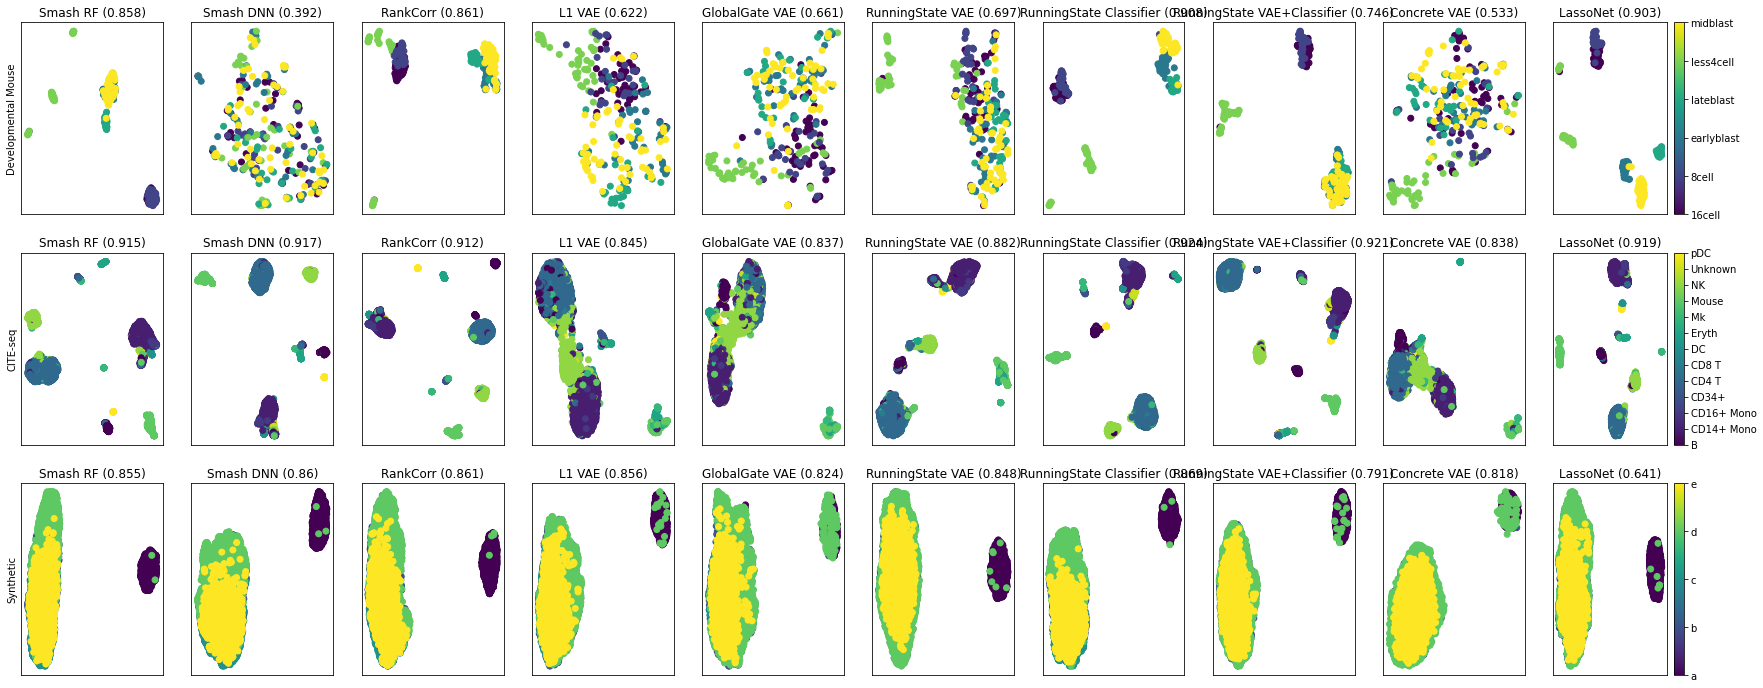

CPU times: user 13min 20s, sys: 7.1 s, total: 13min 28s
Wall time: 10min 20s


In [17]:
%%time

fig, axs = plt.subplots(nrows=3, ncols = len(methods), figsize = (30, 12))

plot_row(axs[0], 'Developmental Mouse', encoder_dm, methods)
plot_row(axs[1], 'CITE-seq', encoder_cs, methods)
plot_row(axs[2], 'Synthetic', encoder_syn, methods)


#plt.tight_layout()
plt.savefig(viz_save_path)
plt.show()

In [18]:
plt.close('all')

# Things to note for paper

PySmash uses a seed internally so the model is deterministic to a particular dataset. We used various different train seeds, whereas the smash paper uses the whole dataset for the data.

For smash DNN, to select the markers, I had to use all the data. Couldn't just use train and val set.

The clusters are not guaranteed to be well separated in the latent space but that is fine.

Global gate vae and concrete vae are similar in performance.

In [19]:
encoder_dm.classes_

array(['16cell', '8cell', 'earlyblast', 'lateblast', 'less4cell',
       'midblast'], dtype=object)